# Basic Filtering with Layer Priors for Deraining on Rain100L



##SETUP AND IMPORTS


In [12]:
!pip install scikit-image
import skimage
print(skimage.__version__)

0.25.2


In [16]:
!pip install scikit-image -q
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import numpy as np
import os
import zipfile
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


##DATA PREPARATION


In [29]:
zip_path = 'archive.zip'
extract_path = 'dataset'

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    DATASET_ROOT = os.path.join(extract_path, 'Rain100L')
else:
    print(f"Error: {zip_path} not found. Please upload your dataset.")


class RainDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.input_dir = os.path.join(root_dir, 'input')
        self.target_dir = os.path.join(root_dir, 'target')
        self.transform = transform
        # Define a fixed size for resizing
        self.image_size = (256, 256)

        self.image_files = [f for f in os.listdir(self.input_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.image_files.sort()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]

        input_path = os.path.join(self.input_dir, img_name)
        target_path = os.path.join(self.target_dir, img_name)

        input_image = cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2RGB)
        target_image = cv2.cvtColor(cv2.imread(target_path), cv2.COLOR_BGR2RGB)

        # Resize images to a fixed size
        input_image = cv2.resize(input_image, self.image_size)
        target_image = cv2.resize(target_image, self.image_size)


        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the full dataset instance
full_dataset = RainDataset(root_dir=DATASET_ROOT, transform=transform)


# Split into training, validation, and test sets (e.g., 80-10-10 split)
dataset_size = len(full_dataset)
# Ensure at least one image per set
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders for all three sets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

print(f"Dataset loaded successfully.")
print(f"Total images: {len(full_dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Test images: {len(test_dataset)}")

Dataset loaded successfully.
Total images: 100
Training images: 80
Validation images: 10
Test images: 10


##MODEL DEFINITION

In [30]:

class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return x + self.conv_block(x)

class DerainNet(nn.Module):
    def __init__(self, num_res_blocks=5):
        super(DerainNet, self).__init__()

        self.conv_in = nn.Conv2d(3, 64, kernel_size=3, padding=1)

        res_blocks = [ResBlock(64) for _ in range(num_res_blocks)]
        self.res_blocks = nn.Sequential(*res_blocks)

        self.conv_out = nn.Conv2d(64, 3, kernel_size=3, padding=1)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        with torch.no_grad():
            # Converting to numpy for cv2.GaussianBlur
            x_np = x.cpu().numpy().transpose(0, 2, 3, 1)
            base_layer_np = np.zeros_like(x_np)
            for i in range(x_np.shape[0]):
                base_layer_np[i] = cv2.GaussianBlur(x_np[i], (21, 21), 0)

            base_layer = torch.from_numpy(base_layer_np.transpose(0, 3, 1, 2)).to(x.device)

        # Detail Layer = Original Image - Base Layer
        detail_layer = x - base_layer

        # Now, feed the detail layer into the CNN
        x_in = self.relu(self.conv_in(detail_layer))
        x_res = self.res_blocks(x_in)

        # Predict the rain component (a residual map)
        rain_prediction = self.conv_out(x_res)

        # The final clean image is the original rainy image minus the predicted rain
        clean_image_prediction = x - rain_prediction

        return clean_image_prediction

# Instantiate the model and move it to the GPU
model = DerainNet().to(device)
print("Model defined and moved to device.")
print(model)

Model defined and moved to device.
DerainNet(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res_blocks): Sequential(
    (0): ResBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ResBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): ResBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): ResBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kern

## TRAINING THE MODEL

Epoch 1/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.07it/s, val_loss=0.00367]


Epoch 1/50 -> Train Loss: 0.004286, Val Loss: 0.002409


Epoch 2/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s, val_loss=0.00271]


Epoch 2/50 -> Train Loss: 0.002689, Val Loss: 0.002105


Epoch 3/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.42it/s, val_loss=0.0022]


Epoch 3/50 -> Train Loss: 0.002172, Val Loss: 0.001686


Epoch 4/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s, val_loss=0.002]


Epoch 4/50 -> Train Loss: 0.001924, Val Loss: 0.001564


Epoch 5/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s, val_loss=0.00182]


Epoch 5/50 -> Train Loss: 0.001816, Val Loss: 0.001508


Epoch 6/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.24it/s, val_loss=0.00169]


Epoch 6/50 -> Train Loss: 0.001727, Val Loss: 0.001426


Epoch 7/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s, val_loss=0.00162]


Epoch 7/50 -> Train Loss: 0.001639, Val Loss: 0.001354


Epoch 8/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.92it/s, val_loss=0.00151]


Epoch 8/50 -> Train Loss: 0.001573, Val Loss: 0.001307


Epoch 9/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.19it/s, val_loss=0.00156]


Epoch 9/50 -> Train Loss: 0.001519, Val Loss: 0.001288


Epoch 10/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.44it/s, val_loss=0.00141]


Epoch 10/50 -> Train Loss: 0.001470, Val Loss: 0.001320


Epoch 11/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.24it/s, val_loss=0.00134]


Epoch 11/50 -> Train Loss: 0.001520, Val Loss: 0.001321


Epoch 12/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.22it/s, val_loss=0.00141]


Epoch 12/50 -> Train Loss: 0.001439, Val Loss: 0.001253


Epoch 13/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s, val_loss=0.00129]


Epoch 13/50 -> Train Loss: 0.001390, Val Loss: 0.001200


Epoch 14/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.15it/s, val_loss=0.00131]


Epoch 14/50 -> Train Loss: 0.001339, Val Loss: 0.001183


Epoch 15/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.25it/s, val_loss=0.00125]


Epoch 15/50 -> Train Loss: 0.001326, Val Loss: 0.001172


Epoch 16/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.21it/s, val_loss=0.00134]


Epoch 16/50 -> Train Loss: 0.001303, Val Loss: 0.001179


Epoch 17/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.19it/s, val_loss=0.00121]


Epoch 17/50 -> Train Loss: 0.001313, Val Loss: 0.001138


Epoch 18/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s, val_loss=0.00128]


Epoch 18/50 -> Train Loss: 0.001298, Val Loss: 0.001140


Epoch 19/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s, val_loss=0.00108]


Epoch 19/50 -> Train Loss: 0.001272, Val Loss: 0.001132


Epoch 20/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.33it/s, val_loss=0.00134]


Epoch 20/50 -> Train Loss: 0.001266, Val Loss: 0.001194


Epoch 21/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.30it/s, val_loss=0.00119]


Epoch 21/50 -> Train Loss: 0.001247, Val Loss: 0.001133


Epoch 22/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.21it/s, val_loss=0.00115]


Epoch 22/50 -> Train Loss: 0.001257, Val Loss: 0.001119


Epoch 23/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.20it/s, val_loss=0.00102]


Epoch 23/50 -> Train Loss: 0.001223, Val Loss: 0.001082


Epoch 24/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.32it/s, val_loss=0.00115]


Epoch 24/50 -> Train Loss: 0.001180, Val Loss: 0.001071


Epoch 25/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.95it/s, val_loss=0.000965]


Epoch 25/50 -> Train Loss: 0.001176, Val Loss: 0.001068


Epoch 26/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.24it/s, val_loss=0.00103]


Epoch 26/50 -> Train Loss: 0.001167, Val Loss: 0.001020


Epoch 27/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.09it/s, val_loss=0.000993]


Epoch 27/50 -> Train Loss: 0.001132, Val Loss: 0.001020


Epoch 28/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.11it/s, val_loss=0.00126]


Epoch 28/50 -> Train Loss: 0.001148, Val Loss: 0.001107


Epoch 29/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.32it/s, val_loss=0.000979]


Epoch 29/50 -> Train Loss: 0.001196, Val Loss: 0.001001


Epoch 30/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s, val_loss=0.000956]


Epoch 30/50 -> Train Loss: 0.001175, Val Loss: 0.001025


Epoch 31/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.28it/s, val_loss=0.00104]


Epoch 31/50 -> Train Loss: 0.001130, Val Loss: 0.001009


Epoch 32/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.33it/s, val_loss=0.000923]


Epoch 32/50 -> Train Loss: 0.001115, Val Loss: 0.001002


Epoch 33/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.18it/s, val_loss=0.000918]


Epoch 33/50 -> Train Loss: 0.001112, Val Loss: 0.001019


Epoch 34/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.33it/s, val_loss=0.000972]


Epoch 34/50 -> Train Loss: 0.001122, Val Loss: 0.000982


Epoch 35/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.26it/s, val_loss=0.00103]


Epoch 35/50 -> Train Loss: 0.001183, Val Loss: 0.001025


Epoch 36/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.98it/s, val_loss=0.000995]


Epoch 36/50 -> Train Loss: 0.001096, Val Loss: 0.000984


Epoch 37/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.24it/s, val_loss=0.000942]


Epoch 37/50 -> Train Loss: 0.001069, Val Loss: 0.000971


Epoch 38/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.30it/s, val_loss=0.00108]


Epoch 38/50 -> Train Loss: 0.001067, Val Loss: 0.001017


Epoch 39/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s, val_loss=0.000939]


Epoch 39/50 -> Train Loss: 0.001083, Val Loss: 0.000963


Epoch 40/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.34it/s, val_loss=0.000899]


Epoch 40/50 -> Train Loss: 0.001080, Val Loss: 0.000948


Epoch 41/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.33it/s, val_loss=0.000889]


Epoch 41/50 -> Train Loss: 0.001058, Val Loss: 0.000937


Epoch 42/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.18it/s, val_loss=0.000926]


Epoch 42/50 -> Train Loss: 0.001050, Val Loss: 0.000952


Epoch 43/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  3.47it/s, val_loss=0.00097]


Epoch 43/50 -> Train Loss: 0.001040, Val Loss: 0.000955


Epoch 44/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.88it/s, val_loss=0.000935]


Epoch 44/50 -> Train Loss: 0.001069, Val Loss: 0.000937


Epoch 45/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.23it/s, val_loss=0.000982]


Epoch 45/50 -> Train Loss: 0.001019, Val Loss: 0.000951


Epoch 46/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  3.57it/s, val_loss=0.000855]


Epoch 46/50 -> Train Loss: 0.001037, Val Loss: 0.000940


Epoch 47/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.33it/s, val_loss=0.000973]


Epoch 47/50 -> Train Loss: 0.001054, Val Loss: 0.000950


Epoch 48/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.32it/s, val_loss=0.001]


Epoch 48/50 -> Train Loss: 0.001026, Val Loss: 0.000967


Epoch 49/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.31it/s, val_loss=0.000939]


Epoch 49/50 -> Train Loss: 0.001049, Val Loss: 0.000932


Epoch 50/50 [Val]: 100%|██████████| 2/2 [00:00<00:00,  5.32it/s, val_loss=0.000975]


Epoch 50/50 -> Train Loss: 0.001006, Val Loss: 0.000967
Finished Training


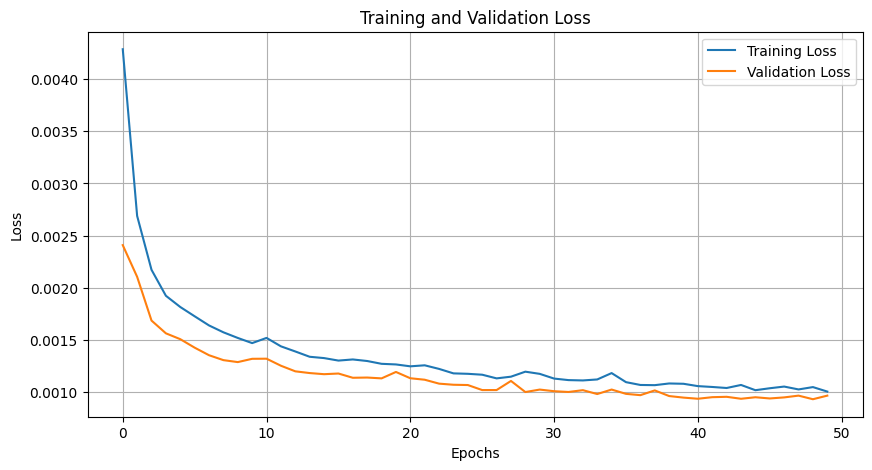

In [31]:
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for inputs, targets in train_pbar:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            train_pbar.set_postfix({'loss': loss.item()})

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for inputs, targets in val_pbar:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * inputs.size(0)
                val_pbar.set_postfix({'val_loss': loss.item()})

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")

    print("Finished Training")
    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)

if train_losses and val_losses:
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


##EVALUATION


--- Final Evaluation on Test Set ---


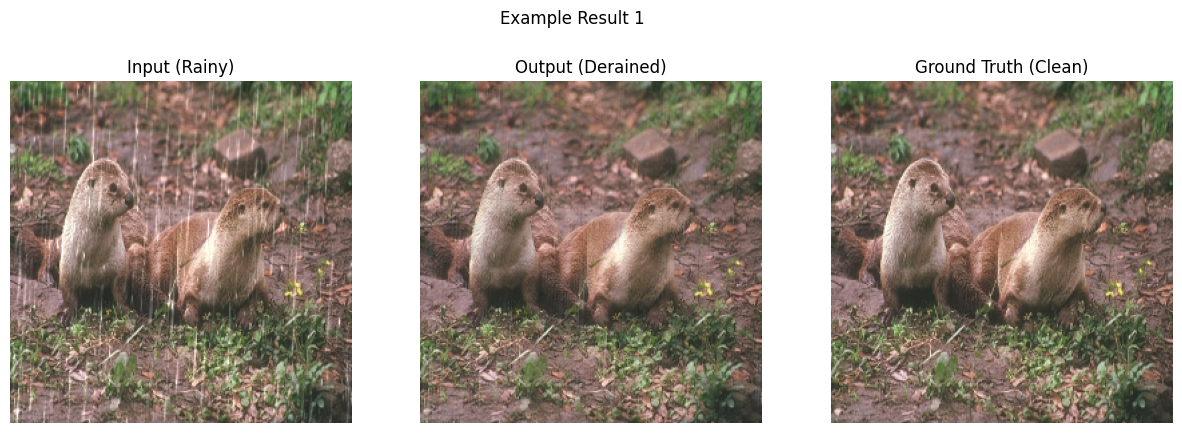

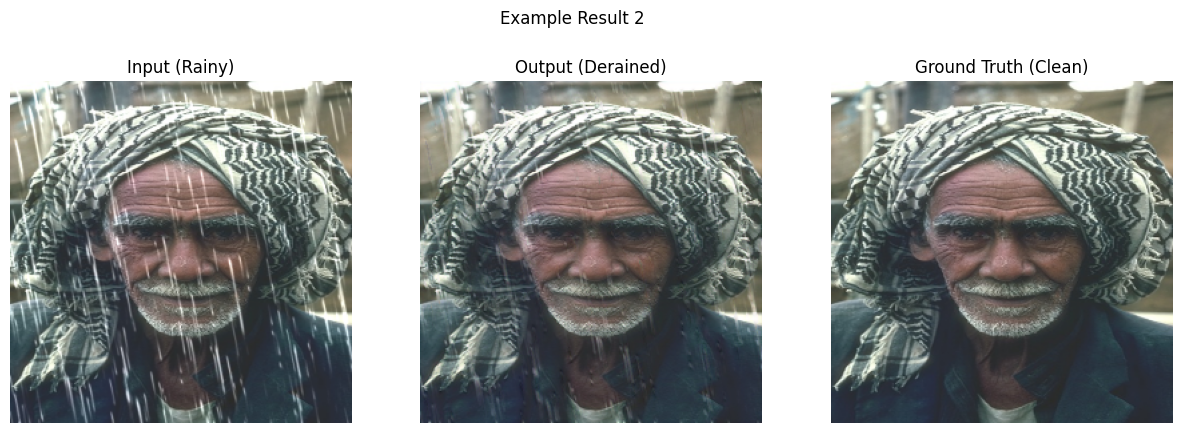


--- Evaluation Summary ---
Average PSNR (Input vs. GT): 27.11 dB
Average SSIM (Input vs. GT): 0.8446
--------------------
Average PSNR (Output vs. GT): 30.95 dB
Average SSIM (Output vs. GT): 0.9247
--------------------
PSNR Improvement: 3.84 dB
SSIM Improvement: 0.0802


In [32]:

def evaluate_model(model, data_loader, device, num_images=5):

    model.eval()
    total_psnr_input = 0
    total_ssim_input = 0
    total_psnr_output = 0
    total_ssim_output = 0
    count = 0

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            inputs_np = inputs.cpu().numpy().transpose(0, 2, 3, 1)
            outputs_np = outputs.cpu().numpy().transpose(0, 2, 3, 1)
            targets_np = targets.cpu().numpy().transpose(0, 2, 3, 1)

            inputs_np = np.clip(inputs_np, 0, 1)
            outputs_np = np.clip(outputs_np, 0, 1)
            targets_np = np.clip(targets_np, 0, 1)

            for j in range(inputs.size(0)):
                rainy_img = inputs_np[j]
                clean_img = targets_np[j]
                derained_img = outputs_np[j]

                total_psnr_input += psnr(clean_img, rainy_img, data_range=1.0)
                total_ssim_input += ssim(clean_img, rainy_img, multichannel=True, channel_axis=2, data_range=1.0)

                total_psnr_output += psnr(clean_img, derained_img, data_range=1.0)
                total_ssim_output += ssim(clean_img, derained_img, multichannel=True, channel_axis=2, data_range=1.0)

                count += 1

            if i < num_images:
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(inputs_np[0])
                axes[0].set_title('Input (Rainy)')
                axes[0].axis('off')

                axes[1].imshow(outputs_np[0])
                axes[1].set_title('Output (Derained)')
                axes[1].axis('off')

                axes[2].imshow(targets_np[0])
                axes[2].set_title('Ground Truth (Clean)')
                axes[2].axis('off')

                plt.suptitle(f'Example Result {i+1}')
                plt.show()

    avg_psnr_input = total_psnr_input / count
    avg_ssim_input = total_ssim_input / count
    avg_psnr_output = total_psnr_output / count
    avg_ssim_output = total_ssim_output / count

    print("\n--- Evaluation Summary ---")
    print(f"Average PSNR (Input vs. GT): {avg_psnr_input:.2f} dB")
    print(f"Average SSIM (Input vs. GT): {avg_ssim_input:.4f}")
    print("-" * 20)
    print(f"Average PSNR (Output vs. GT): {avg_psnr_output:.2f} dB")
    print(f"Average SSIM (Output vs. GT): {avg_ssim_output:.4f}")
    print("-" * 20)
    print(f"PSNR Improvement: {avg_psnr_output - avg_psnr_input:.2f} dB")
    print(f"SSIM Improvement: {avg_ssim_output - avg_ssim_input:.4f}")

print("\n--- Final Evaluation on Test Set ---")
evaluate_model(model, test_loader, device)